In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
import yfinance as yf
print(yf.__version__)


0.2.63


In [3]:
# fetch data from Yahoo Finance
ticker = "^NDX"  # NASDAQ 100
data = yf.download(ticker, period="max", interval="1d", threads=False)  # daily data
data = data[['Close']]

C:\Users\PC\AppData\Local\Temp\ipykernel_15940\3815366490.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="max", interval="1d", threads=False)  # daily data
[*********************100%***********************]  1 of 1 completed


In [4]:
data

Price,Close
Ticker,^NDX
Date,
1985-10-01,112.139999
1985-10-02,110.824997
1985-10-03,110.870003
1985-10-04,110.074997
1985-10-07,108.199997
...,...
2025-06-11,21860.800781
2025-06-12,21913.320312


In [5]:
data.shape

(10006, 1)

In [6]:
# normalizing data using scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']]) 

In [7]:
# %% Create sequences from full scaled data
seq_length = 60
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_data, seq_length)


In [8]:
# %% Split into training, validation, test sets
total_samples = len(X_all)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_val = X_all[train_size:train_size + val_size]
y_val = y_all[train_size:train_size + val_size]
X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (6962, 60, 1), y_train shape: (6962, 1)
X_val shape: (1491, 60, 1), y_val shape: (1491, 1)
X_test shape: (1493, 60, 1), y_test shape: (1493, 1)


In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss=Huber())

In [10]:
#from tensorflow.keras.models import load_model
#model = load_model("lstm_model_ndx.h5")

In [11]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/200

218/218 [==============================] - 9s 35ms/step - loss: 4.5551e-05 - val_loss: 3.0176e-05
Epoch 2/200
218/218 [==============================] - 7s 33ms/step - loss: 1.2074e-05 - val_loss: 1.3635e-04
Epoch 3/200
218/218 [==============================] - 7s 34ms/step - loss: 1.1678e-05 - val_loss: 1.5712e-05
Epoch 4/200
218/218 [==============================] - 7s 33ms/step - loss: 9.4318e-06 - val_loss: 2.4880e-05
Epoch 5/200
218/218 [==============================] - 7s 33ms/step - loss: 1.0556e-05 - val_loss: 3.7004e-05
Epoch 6/200
218/218 [==============================] - 7s 33ms/step - loss: 9.9647e-06 - val_loss: 7.3658e-05
Epoch 7/200
218/218 [==============================] - 7s 33ms/step - loss: 9.3909e-06 - val_loss: 4.9970e-05
Epoch 8/200
218/218 [==============================] - 7s 33ms/step - loss: 9.3250e-06 - val_loss: 1.0290e-04
Epoch 9/200
218/218 [==============================] - 7s 33ms/step - loss: 9.7009e-06 - val_loss: 6.1544e-05
Epoch 10/

In [13]:
#model.save_weights("lstm.weights.h5")

In [14]:
#model.save("lstm_model_ndx.h5")


In [19]:
data.tail

<bound method NDFrame.tail of Price              Close
Ticker              ^NDX
Date                    
1985-10-01    112.139999
1985-10-02    110.824997
1985-10-03    110.870003
1985-10-04    110.074997
1985-10-07    108.199997
...                  ...
2025-06-11  21860.800781
2025-06-12  21913.320312
2025-06-13  21631.039062
2025-06-16  21937.570312
2025-06-17  21719.080078

[10006 rows x 1 columns]>

In [20]:
test_dates = data.index[train_size + val_size + seq_length:]

In [21]:
test_dates

DatetimeIndex(['2019-07-11', '2019-07-12', '2019-07-15', '2019-07-16',
               '2019-07-17', '2019-07-18', '2019-07-19', '2019-07-22',
               '2019-07-23', '2019-07-24',
               ...
               '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-09',
               '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13',
               '2025-06-16', '2025-06-17'],
              dtype='datetime64[ns]', name='Date', length=1493, freq=None)

In [27]:
# Predict
y_pred_scaled = model.predict(X_test)

# Reshape for inverse transformation
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse transform using the same scaler
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test = scaler.inverse_transform(y_test_scaled)

# Use the rescaled values
predictions_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test.flatten(),
    'Predicted Price': y_pred.flatten()
})


47/47 [==============================] - 1s 11ms/step


In [28]:
print(predictions_df.head())

        Date  Actual Price  Predicted Price
0 2019-07-11   7896.779785      7800.207031
1 2019-07-12   7943.240234      7821.175781
2 2019-07-15   7966.930176      7845.364746
3 2019-07-16   7927.080078      7871.099121
4 2019-07-17   7888.759766      7888.486328


In [29]:
print(predictions_df.tail())

           Date  Actual Price  Predicted Price
1488 2025-06-11  21860.800781     20663.654297
1489 2025-06-12  21913.320312     20713.683594
1490 2025-06-13  21631.039062     20756.107422
1491 2025-06-16  21937.570312     20752.451172
1492 2025-06-17  21719.080078     20765.185547


In [30]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
directional_accuracy = np.mean((np.sign(np.diff(y_test.flatten())) == np.sign(np.diff(y_pred.flatten())))) * 100

In [ ]:
# Plot training & validation loss
#plt.figure(figsize=(12, 6))
#plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()


In [31]:
print("Scaler Min Value:", scaler.data_min_)
print("Scaler Max Value:", scaler.data_max_)
print("First 10 Predicted Values (Inverse Transformed):", y_pred[:10])
print("First 10 Actual Values (Inverse Transformed):", y_test[:10])

Scaler Min Value: [107.16000366]
Scaler Max Value: [22175.59960938]
First 10 Predicted Values (Inverse Transformed): [[7800.207 ]
 [7821.176 ]
 [7845.3647]
 [7871.099 ]
 [7888.4863]
 [7893.7446]
 [7894.0103]
 [7881.956 ]
 [7874.8193]
 [7878.0024]]
First 10 Actual Values (Inverse Transformed): [[7896.77978516]
 [7943.24023438]
 [7966.93017578]
 [7927.08007812]
 [7888.75976562]
 [7904.12988281]
 [7834.89990234]
 [7905.12011719]
 [7954.56005859]
 [8010.60986328]]


In [32]:
print("Last 10 Predicted Values (Inverse Transformed):", y_pred[-10:])
print("Last 10 Actual Values (Inverse Transformed):", y_test[-10:])

Last 10 Predicted Values (Inverse Transformed): [[20378.197]
 [20449.312]
 [20493.95 ]
 [20546.348]
 [20599.479]
 [20663.654]
 [20713.684]
 [20756.107]
 [20752.451]
 [20765.186]]
Last 10 Actual Values (Inverse Transformed): [[21721.91992188]
 [21547.4296875 ]
 [21761.7890625 ]
 [21797.86914062]
 [21941.91992188]
 [21860.80078125]
 [21913.3203125 ]
 [21631.0390625 ]
 [21937.5703125 ]
 [21719.08007812]]


In [33]:
# Performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
directional_accuracy = np.mean((np.sign(np.diff(y_test.flatten())) == np.sign(np.diff(y_pred.flatten())))) * 100
mape_percentage = 100 - mape
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Mape Percentage: {mape_percentage:.2f}%")



Mean Squared Error: 341492.8248
Root Mean Squared Error: 584.3739
Mean Absolute Error: 459.6304
R-squared Score: 0.9771
Explained Variance Score: 0.9880
Mean Absolute Percentage Error: 3.0041
Directional Accuracy: 51.47%
Mape Percentage: 97.00%


- Mean Squared Error: 1157069.5461
- Root Mean Squared Error: 1075.6717
- Mean Absolute Error: 786.8268
- R-squared Score: 0.9164
- Explained Variance Score: 0.9563
- Mean Absolute Percentage Error: 4.8413
- Directional Accuracy: 51.53%
- Mape Percentage: 95.16%

NameError: name 'train_data' is not defined

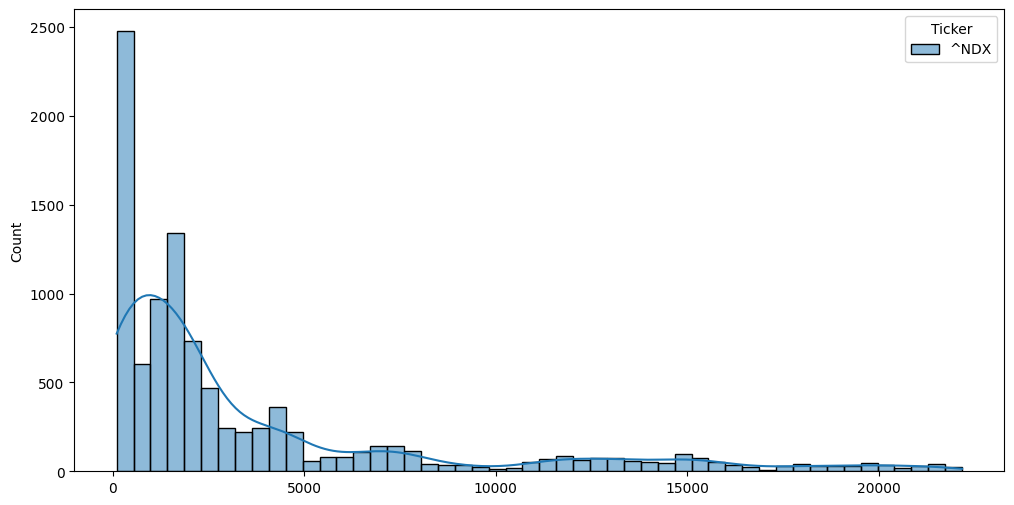

In [39]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Close'], bins=50, kde=True, label='All Data', color='blue')
sns.histplot(train_data['Close'], bins=50, kde=True, label='Training Data', color='green')
sns.histplot(test_data['Close'], bins=50, kde=True, label='Testing Data', color='red')
plt.legend()
plt.title("Distribution of Close Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()


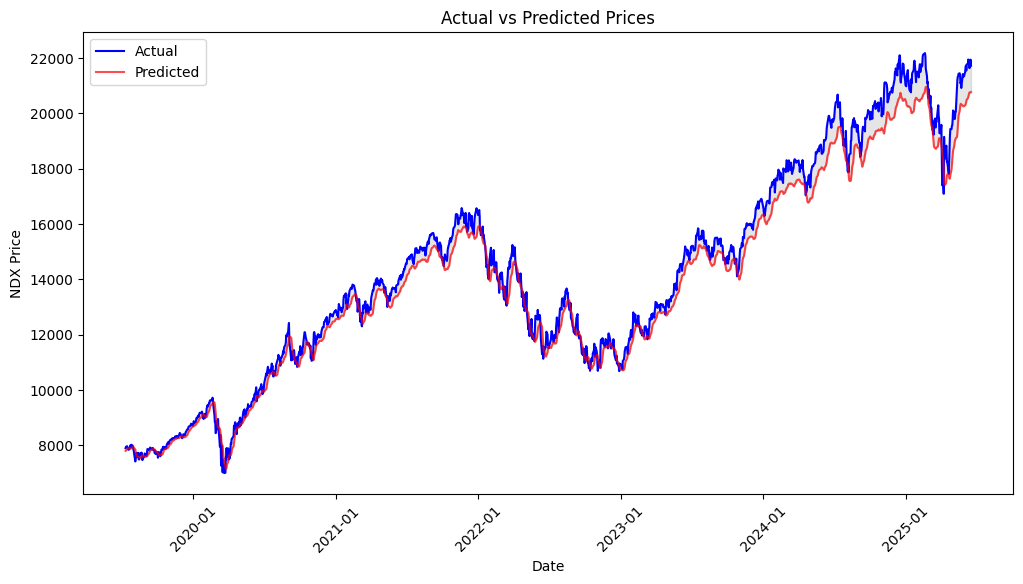

In [35]:
import matplotlib.dates as mdates
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Date'], predictions_df['Actual Price'], label='Actual', color='blue')
plt.plot(predictions_df['Date'], predictions_df['Predicted Price'], label='Predicted', color='red', alpha=0.7)
plt.fill_between(predictions_df['Date'], predictions_df['Actual Price'], predictions_df['Predicted Price'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

In [ ]:
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
selected_date = pd.to_datetime("2024-11-07")

selected_row = predictions_df[predictions_df['Date'] == selected_date]

if not selected_row.empty:
    print(f"Predicted and Actual price on {selected_date.date()}:")
    print(selected_row)
else:
    print(f"No prediction available for {selected_date.date()}.")


Predicted and Actual price on 2024-11-07:
           Date  Actual Price  Predicted Price
1312 2024-11-07  21101.570312     18076.650391


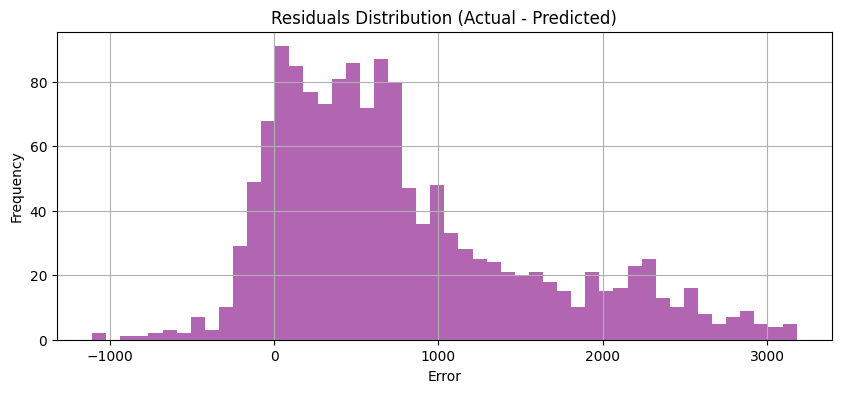

In [ ]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50, color='purple', alpha=0.6)
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

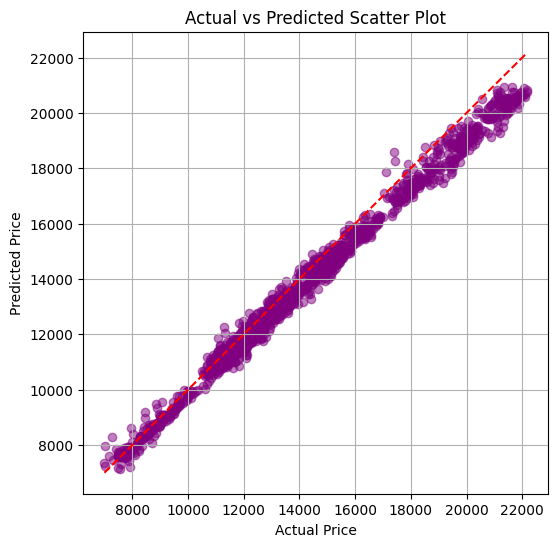

In [36]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Scatter Plot")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()


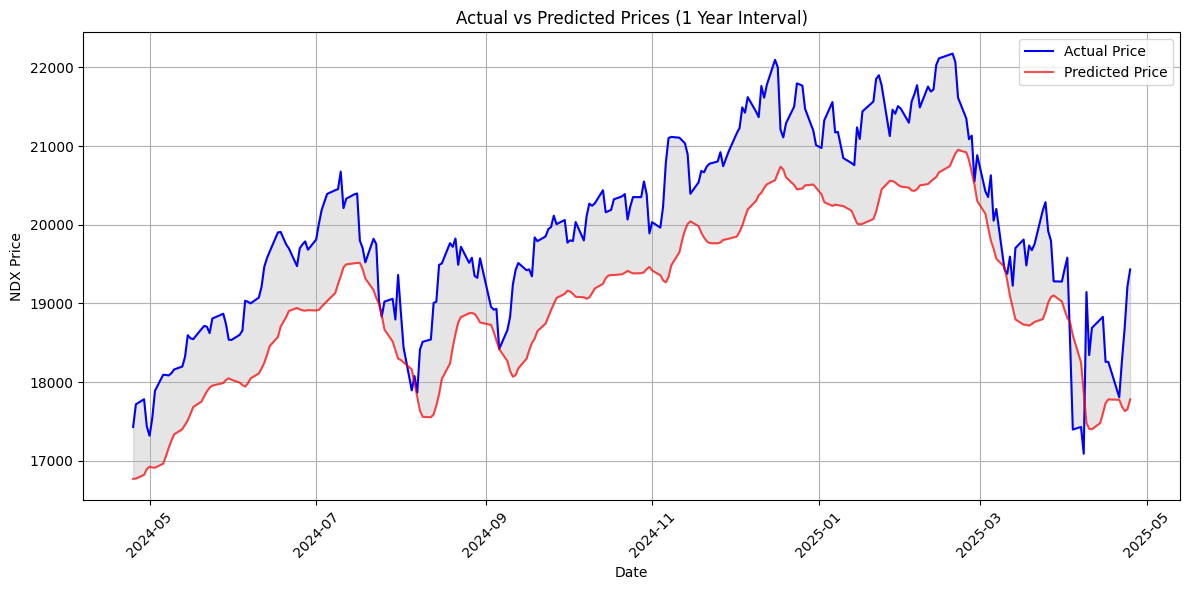

In [37]:
start_date = pd.to_datetime("2024-04-25")
end_date = pd.to_datetime("2025-04-25")

one_year_df = predictions_df[(predictions_df['Date'] >= start_date) & (predictions_df['Date'] <= end_date)]

plt.figure(figsize=(12, 6))
plt.plot(one_year_df['Date'], one_year_df['Actual Price'], label='Actual Price', color='blue')
plt.plot(one_year_df['Date'], one_year_df['Predicted Price'], label='Predicted Price', color='red', alpha=0.7)
plt.fill_between(one_year_df['Date'], one_year_df['Actual Price'], one_year_df['Predicted Price'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.title('Actual vs Predicted Prices (1 Year Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from datetime import timedelta
last_sequence = scaled_test_data[-seq_length:].reshape(1, seq_length, 1)
next_day_prediction = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_prediction)

last_date = pd.to_datetime(test_data.index[-1])


next_date = last_date + timedelta(days=1)
while next_date.weekday() >= 5:  
    next_date += timedelta(days=1)


print(f"Predicted price for {next_date.date()}: {next_day_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted price for 2025-05-12: 17901.95


In [ ]:
data.tail

<bound method NDFrame.tail of Price              Close
Ticker              ^NDX
Date                    
1985-10-01    112.139999
1985-10-02    110.824997
1985-10-03    110.870003
1985-10-04    110.074997
1985-10-07    108.199997
...                  ...
2025-05-05  19967.939453
2025-05-06  19791.349609
2025-05-07  19867.970703
2025-05-08  20063.560547
2025-05-09  20061.449219

[9980 rows x 1 columns]>

In [ ]:
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
selected_date = pd.to_datetime("2025-04-25")

selected_row = predictions_df[predictions_df['Date'] == selected_date]

if not selected_row.empty:
    print(f"Predicted and Actual price on {selected_date.date()}:")
    print(selected_row)
else:
    print(f"No prediction available for {selected_date.date()}.")


Predicted and Actual price on 2025-04-25:
           Date  Actual Price  Predicted Price
1426 2025-04-25  19432.560547     16911.462891


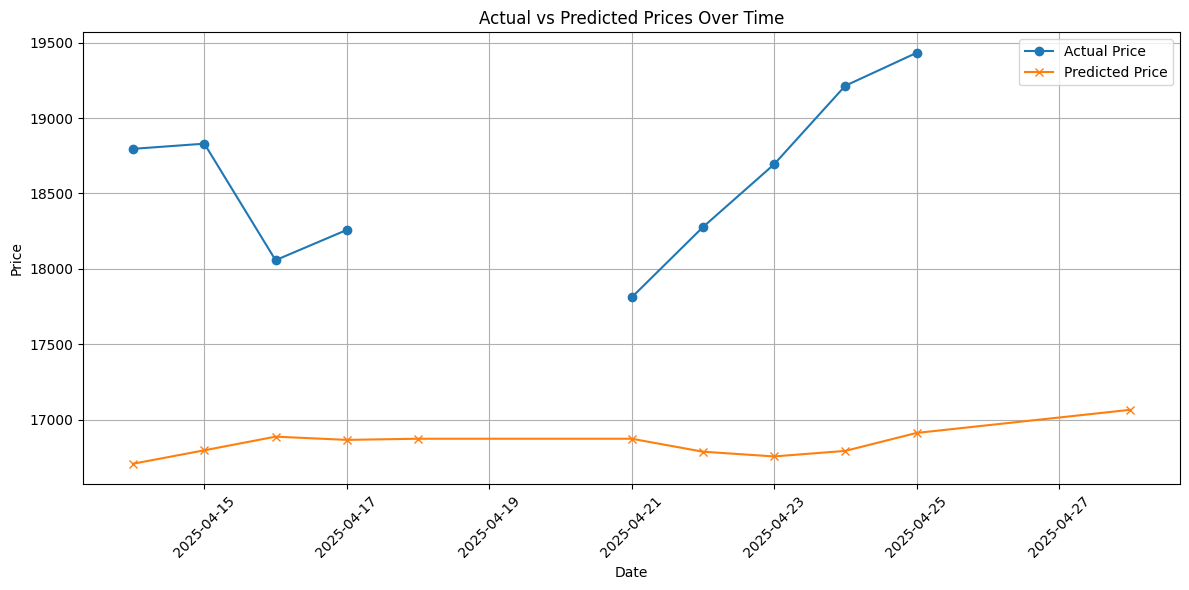

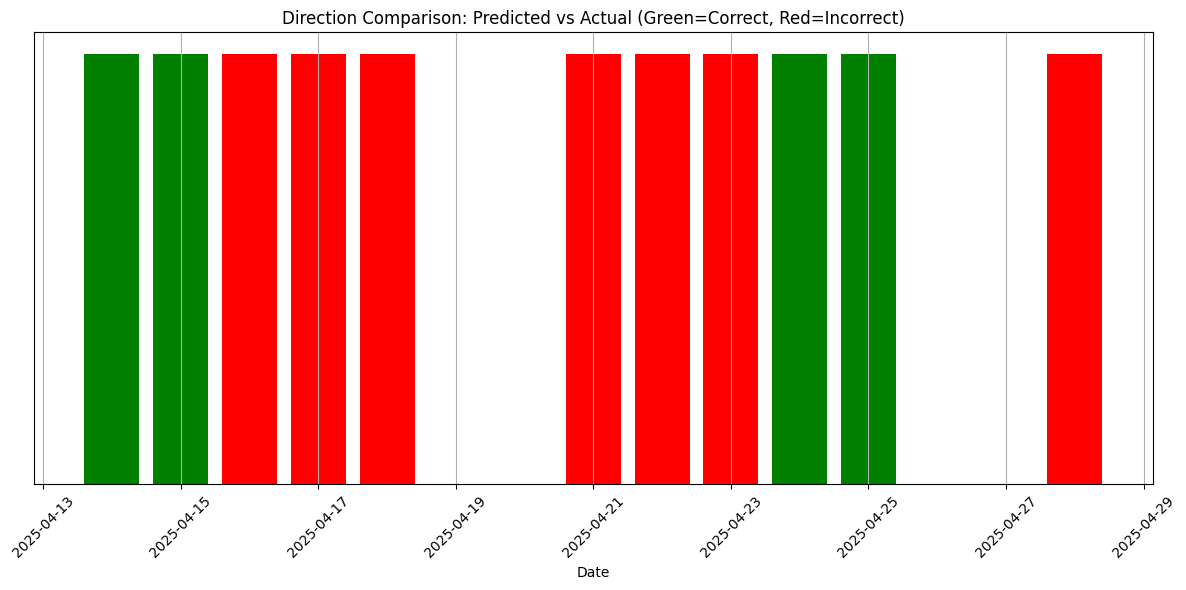

In [ ]:
data = {
    'Date': [
        '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17', '2025-04-18',
        '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-28'
    ],
    'Predicted': [
        16707.42, 16796.37, 16886.89, 16865.50, 16873.11,
        16873.111328, 16787.195312, 16755.701172, 16792.482422, 16911.462891, 17064.93
    ],
    'Actual': [
        18796.021484, 18830.226562, 18057.457031, 18258.089844, None,
        17810.380859, 18276.410156, 18693.259766, 19214.400391, 19432.560547, None
    ]
}

# DataFrame oluştur
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# İlk Plot: Tarihe göre Actual vs Predicted Price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Actual'], label='Actual Price', marker='o')
plt.plot(df.index, df['Predicted'], label='Predicted Price', marker='x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


df['Actual_Change'] = df['Actual'].diff()
df['Predicted_Change'] = df['Predicted'].diff()

df['Actual_Direction'] = df['Actual_Change'].apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change'))
df['Predicted_Direction'] = df['Predicted_Change'].apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change'))


colors = []
for actual, predicted in zip(df['Actual_Direction'], df['Predicted_Direction']):
    if actual == predicted:
        colors.append('green')  
    else:
        colors.append('red')  

# Bar plot çizimi
plt.figure(figsize=(12,6))
plt.bar(df.index, [1]*len(df), color=colors)
plt.xlabel('Date')
plt.title('Direction Comparison: Predicted vs Actual (Green=Correct, Red=Incorrect)')
plt.yticks([])
plt.grid(axis='x')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
valid_days = df.dropna(subset=['Actual_Change'])
correct_predictions = (valid_days['Actual_Direction'] == valid_days['Predicted_Direction']).sum()
total_predictions = len(valid_days)
directional_accuracy = correct_predictions / total_predictions

print(f"Directional Accuracy: {directional_accuracy:.2%}")


Directional Accuracy: 42.86%


In [ ]:
weekly_predicted_first = df['Predicted'].resample('W-MON').first()
weekly_predicted_last = df['Predicted'].resample('W-MON').last()
weekly_predicted_change = weekly_predicted_last - weekly_predicted_first
weekly_predicted_trend = weekly_predicted_change.apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change'))


weekly_actual_first = df['Actual'].resample('W-MON').first()
weekly_actual_last = df['Actual'].resample('W-MON').last()
weekly_actual_change = weekly_actual_last - weekly_actual_first
weekly_actual_trend = weekly_actual_change.apply(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change'))

weekly_analysis = pd.DataFrame({
    'First Predicted Price': weekly_predicted_first,
    'Last Predicted Price': weekly_predicted_last,
    'Predicted Weekly Trend': weekly_predicted_trend,
    'First Actual Price': weekly_actual_first,
    'Last Actual Price': weekly_actual_last,
    'Actual Weekly Trend': weekly_actual_trend
})


weekly_analysis['Trend Match'] = weekly_analysis['Predicted Weekly Trend'] == weekly_analysis['Actual Weekly Trend']


correct_weeks = weekly_analysis['Trend Match'].sum()
total_weeks = len(weekly_analysis.dropna())  
weekly_directional_accuracy = correct_weeks / total_weeks


print(weekly_analysis)
print(f"\nWeekly Directional Accuracy: {weekly_directional_accuracy:.2%}")


            First Predicted Price  Last Predicted Price  \
Date                                                      
2025-04-14           16707.420000          16707.420000   
2025-04-21           16796.370000          16873.111328   
2025-04-28           16787.195312          17064.930000   

           Predicted Weekly Trend  First Actual Price  Last Actual Price  \
Date                                                                       
2025-04-14              No Change        18796.021484       18796.021484   
2025-04-21                     Up        18830.226562       17810.380859   
2025-04-28                     Up        18276.410156       19432.560547   

           Actual Weekly Trend  Trend Match  
Date                                         
2025-04-14           No Change         True  
2025-04-21                Down        False  
2025-04-28                  Up         True  

Weekly Directional Accuracy: 66.67%
